In [15]:
import wrds
import pandas_datareader
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
from decimal import Decimal

In [16]:
load_data = False
data_folder = '/Users/Xinlin/Desktop/Quantitative Asset Management/Problem Sets/PS1/'
wrds_id = 'yxinlin'

min_shrcd = 10
max_shrcd = 11
min_year = 1925
max_year = 2021
possible_exchcd = (1, 2, 3)

if load_data:
    conn = wrds.Connection(wrds_username=wrds_id)
    # load CRSP returns
    crsp_raw = conn.raw_sql("""
                          select a.permno, a.date, a.ret, a.shrout, a.prc,
                          b.shrcd, b.exchcd
                          from crspq.msf as a
                          left join crspq.msenames as b
                          on a.permno=b.permno
                          and b.namedt<=a.date
                          and a.date<=b.nameendt
                          where b.shrcd between """ + str(min_shrcd) + """ and  """ + str(max_shrcd) + """
                          and a.date between '01/01/""" +str(min_year)+ """' and '12/31/""" +str(max_year)+ """'
                          and b.exchcd in """ + str(possible_exchcd) + """
                          """)
    # load CRSP delisting returns
    dlret_raw = conn.raw_sql("""
                            select permno, dlstdt, dlret, dlstcd
                            from crspq.msedelist
                            """)
    conn.close()
    
    # save pkl
    crsp_raw.to_csv('crsp_raw.csv')
    dlret_raw.to_csv('dlret_raw.csv')

else:
    crsp_raw = pd.read_csv('crsp_raw.csv')
    dlret_raw = pd.read_csv('dlret_raw.csv')                      

In [17]:
#load Fama-French 3 factors data
load_data = False

if load_data:
    pd.set_option('precision', 4)
    ff3 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', start='1926', end='2022')
    ff3 = ff3.read()[0]/100
    ff3.columns = 'MktRF', 'SMB', 'HML', 'RF'
    ff3.to_csv('ff3.csv')

else:
    ff3 = pd.read_csv('ff3.csv')

#### Question 1

In [18]:
# change variables
crsp_raw['permno'] = crsp_raw['permno'].astype(int)
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'], format='%Y-%m-%d', errors='ignore')
crsp_raw['date'] = pd.DataFrame(crsp_raw[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
crsp_raw = crsp_raw.sort_values(by=['date', 'permno'])

dlret_raw.permno = dlret_raw.permno.astype(int)
dlret_raw['date'] = pd.to_datetime(dlret_raw['dlstdt'], format='%Y-%m-%d', errors='ignore')
dlret_raw['date'] = pd.DataFrame(dlret_raw[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
dlret_raw = dlret_raw.sort_values(by=['date', 'permno'])

ff3['date'] = pd.to_datetime(ff3['Date'], format='%Y-%m-%d', errors='ignore')
ff3['date'] = pd.DataFrame(ff3[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)

In [19]:
# merge holding period return data with delisted return data
crsp = crsp_raw.merge(dlret_raw, how='outer', on=['date', 'permno'])

# compute adjusted returns
crsp['ret'] = np.where(crsp['ret'].notna() & crsp['dlret'].notna(), 
                       (1+crsp['ret'])*(1+crsp['dlret'])-1, crsp['ret'])
crsp['ret'] = np.where(crsp['ret'].isna() & crsp['dlret'].notna(),
                       crsp['dlret'], crsp['ret'])
crsp = crsp[crsp['ret'].notna()]
crsp = crsp[['date','permno','prc','shrout','ret']].sort_values(by=['date','permno']).reset_index(drop=True)

In [20]:
# compute market equity
crsp['me'] = crsp['prc'].abs() * crsp['shrout']

In [21]:
# find lagged market equity
crsp['new_date'] = crsp['date'] + dt.timedelta(days=20)
crsp['new_date'] = pd.DataFrame(crsp[['new_date']].values.astype('datetime64[ns]')) + MonthEnd(0)
lcrsp = crsp[['new_date','permno','me']].rename(columns={'new_date':'date', 'me':'lag_me'})
crsp = crsp[['date','permno','ret','me']]
crsp = crsp.merge(lcrsp, how='inner', on=['date','permno'])
crsp = crsp[crsp['ret'].notna() & crsp['lag_me'].notna()]
crsp = crsp.drop_duplicates(subset=['date','permno'])

# compute sum of lag_me at each month-end
sum_lag_me = crsp.groupby(['date'])['lag_me'].sum().reset_index().rename(columns={'lag_me':'stock_lag_mv'})
crsp = crsp.merge(sum_lag_me, how='outer', on='date')

In [22]:
# compute value-weighted return
crsp['lag_weight'] = crsp['lag_me']/crsp['stock_lag_mv']
crsp['vw_ret'] = crsp['ret']*crsp['lag_weight']
vw_ret = crsp.groupby(['date'])['vw_ret'].sum().reset_index().rename(columns={'vw_ret': "stock_vw_ret"})

# compute equal-weighted return
ew_ret = crsp.groupby(['date'])['ret'].mean().reset_index().rename(columns={'ret': "stock_ew_ret"})

In [23]:
monthly_crsp_stock = sum_lag_me.merge(ew_ret, how='inner', on=['date'])
monthly_crsp_stock = monthly_crsp_stock.merge(vw_ret, how='inner', on=['date'])
print(monthly_crsp_stock)

           date  stock_lag_mv  stock_ew_ret  stock_vw_ret
0    1926-02-28  2.678975e+07     -0.053931     -0.033337
1    1926-03-31  2.601718e+07     -0.095597     -0.064564
2    1926-04-30  2.404646e+07      0.031884      0.036917
3    1926-05-31  2.519361e+07      0.002048      0.012303
4    1926-06-30  2.523775e+07      0.051502      0.054721
...         ...           ...           ...           ...
1146 2021-08-31  4.589669e+10      0.022892      0.028814
1147 2021-09-30  4.727925e+10     -0.029714     -0.043681
1148 2021-10-31  4.522362e+10      0.020737      0.066513
1149 2021-11-30  4.826523e+10     -0.053513     -0.015409
1150 2021-12-31  4.745864e+10     -0.008236      0.031500

[1151 rows x 4 columns]


In [24]:
# save output in a csv
monthly_crsp_stock.to_csv('monthly_crsp_stock.csv', encoding='utf-8')

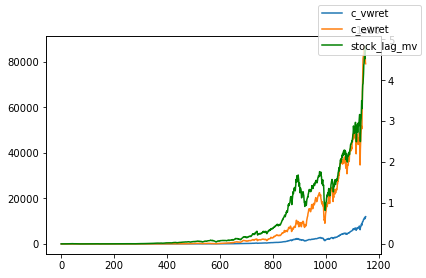

In [25]:
# plot cumulative returns
vw_ret['cum_vw_ret'] = np.cumprod(1+vw_ret['stock_vw_ret']) - 1
ew_ret['cum_ew_ret'] = np.cumprod(1+ew_ret['stock_ew_ret']) - 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(vw_ret['cum_vw_ret'], label='c_vwret')
ax.plot(ew_ret['cum_ew_ret'], label='c_ewret')
ax1 = ax.twinx()
ax1.plot(sum_lag_me['stock_lag_mv'], label='stock_lag_mv', color='green')
fig.legend()
plt.show()

#### Question 2

In [26]:
# comparison with fama-french
df = pd.merge(vw_ret, ff3, how='outer', on=['date'])
df['ret_rep'] = df['stock_vw_ret'] - df['RF']
df = df[['date','ret_rep','MktRF']]
df = df[df['ret_rep'].notna() & df['MktRF'].notna()]

q2 = pd.DataFrame(columns=['Index', 'Replication', 'Fama-French'])

q2.loc[0, 'Index'] = 'Annualized Excess Return'
q2.loc[0, 'Replication'] = df['ret_rep'].mean()*12
q2.loc[0, 'Fama-French'] = df['MktRF'].mean()*12

q2.loc[1, 'Index'] = 'Annualized Standard Deviation'
q2.loc[1, 'Replication'] = df['ret_rep'].std()*np.sqrt(12)
q2.loc[1, 'Fama-French'] = df['MktRF'].std()*np.sqrt(12)

q2.loc[2, 'Index'] = 'Sharpe Ratio'
q2.loc[2, 'Replication'] = df['ret_rep'].mean()*12 / (df['ret_rep'].std()*np.sqrt(12))
q2.loc[2, 'Fama-French'] = df['MktRF'].mean()*12 / (df['MktRF'].std()*np.sqrt(12))

q2.loc[3, 'Index'] = 'Excess Skewness'
q2.loc[3, 'Replication'] = df['ret_rep'].skew()
q2.loc[3, 'Fama-French'] = df['MktRF'].skew()

q2.loc[4, 'Index'] = 'Excess Kurtosis'
q2.loc[4, 'Replication'] = df['ret_rep'].kurtosis()
q2.loc[4, 'Fama-French'] = df['MktRF'].kurtosis()

q2 = q2.set_index('Index')
print(q2)

                              Replication Fama-French
Index                                                
Annualized Excess Return         0.083504    0.083199
Annualized Standard Deviation    0.184557     0.18482
Sharpe Ratio                     0.452457    0.450163
Excess Skewness                  0.170301    0.163392
Excess Kurtosis                  7.656854    7.648277


#### Question 3

In [27]:
# compute correlation with fama-french data
cor = df[['ret_rep', 'MktRF']].corr(method='pearson', min_periods=1)
corr = Decimal(cor.iloc[0,1]).quantize(Decimal("0.00000001"), rounding = "ROUND_HALF_UP")
print(corr)

0.99998998


In [28]:
df['diff'] = df['ret_rep'] - df['MktRF']
max(df['diff'])

0.0024313812602767756